![image](https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cloud/notebooks/headers/watsonx-Prompt_Lab-Notebook.png)

# Prompt Tuning for Binary Classification with watsonx

#### Disclaimers

- Use only Projects and Spaces that are available in watsonx context.

# Overview

## Audience

This notebook is part of a series of notebooks, designed to guide you on how to utilize watsonx.ai Large Language Models (LLMs) for text classification.

The scenario presented in this notebook assumes you have at least 100 labeled text elements in a binary setup, that is, given a category of interest, each text element is labeled as either belongs to this category or not. A <related notebook> provides guidance how to collect such labeled data efficiently.
    
*Add notebook for labeled data colletction for binary classification*

Some familiarity with Python is helpful. This notebook runs with python 3.10.

## Prompt Tuning

Full fine-tuning of LLMs requires significant resources. To this end, watsonx provides Prompt Tuning (PT), a parameter-efficient tuning method where the pre-trained model parameters are frozen and a soft prompt is trained on the labeled data provided. Compared to prompt-engineering, PT allows the LLMs to learn from many more examples, avoiding the prompt length limitation, and aiming at deeper adaptation to the given data. For more details, please refer to <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/fm-tuning-methods.html?context=wx&audience=wdp" target="_blank" rel="noopener no referrer">our documentation.</a>

## Learning goal

- The goal of this notebook is to provide an end-to-end step-by-step walkthrough of using PT in watsonx for binary classification, assuming labeled data exists, and demonstrating how to:
    - Upload a data asset
    - Setup and run PT
    - Deploy tuned model
    - Infer tuned model on test data
    - Evaluate model performance
- We provide advanced steps for making the best of your tuning in various scenarios. For example, How to initialize the soft prompt for classification?
- The notebook is backed by empirical evidence over 6 benchmarks showing an average improvement of ~24 points in macro-f1 compared to zero-shot classification with the same model (see details in the [Benchmark Results](#benchmark) section).

## Contents

This notebook contains the following parts:

- [Setup](#setup)
- [Load data](#load_data)
- [Initialize experiment](#experiment)
- [Run Prompt Tuning](#run_tuning)
- [Deploy](#deploy)
- [Run Foundation Models Inference on `watsonx.ai`](#inference)
- [Evaluate tuned model](#evaluation)
- [Benchmark Results](#benchmark)
- [Summary](#summary)

<a id="setup"></a>
# Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a Watson Machine Learning (WML) Service instance (information about how to create the instance can be found <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-service-instance.html?context=analytics" target="_blank" rel="noopener no referrer">here</a>. A paid instance is required to use Tuning Studio).

## Install dependencies

In [1]:
!pip install ibm-watsonx-ai -U -q
!pip install scikit-learn -q
!pip install matplotlib -q
!pip install wget -q

## Import utility packages

In [2]:
import os
import getpass

### Watsonx API connection
This cell defines the credentials required to work with watsonx API for Foundation
Model inferencing.

**Action:** Provide the IBM Cloud user API url and key. For details, see <a href="https://cloud.ibm.com/docs/account?topic=account-userapikey&interface=ui" target="_blank" rel="noopener no referrer">documentation</a>.

In [3]:
try:
    api_url = os.environ["API_URL"]
except KeyError:
    api_url = getpass.getpass("Please enter your watsonx.ai URL domain (hit enter): ")

Please enter your watsonx.ai URL domain (hit enter): ········


In [4]:
try:
    api_key = os.environ["API_KEY"]
except KeyError:
    api_key = getpass.getpass("Please enter your watsonx.ai API key (hit enter): ")

Please enter your watsonx.ai API key (hit enter): ········


## Define the project id

The Foundation Model requires a project id that provides the context for the call. We will try to obtain the id from the project in which this notebook runs. Otherwise, please provide the project id. To find your project id, select the project from the [project list](https://dataplatform.cloud.ibm.com/projects/?context=wx), and then take the project id from `Manage`->`General`->`Details`.

In [5]:
try:
    project_id = os.environ["PROJECT_ID"]
except KeyError:
    project_id = getpass.getpass("Please enter your watsonx.ai Project ID (hit enter): ")

Please enter your watsonx.ai Project ID (hit enter): ········


Create an instance of APIClient with authentication details, and set the project id.

In [6]:
credentials = {
    "url": api_url,
    "apikey": api_key
}

In [7]:
from ibm_watsonx_ai import APIClient

In [8]:
client = APIClient(credentials)

In [9]:
client.set.default_project(project_id)

'SUCCESS'

<a id="load_data"></a>
# Load data

The recommended data size is between a few hundred and a few thousand exmaples.

For more details read about <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/fm-tuning-data.html?context=wx&audience=wdp" target="_blank" rel="noopener no referrer">data formats</a> in our documentation.

Make sure your class is represented well enough. Models may have a hard time to predict classes that have a small number of examples in the train data.

## Use CFPB data

To illustrate the use of PT for binary classification, we will use a subset of the CFPB (Consumer Financial Protection Bureau) dataset (for more details about the dataset [click here](https://www.consumerfinance.gov/data-research/consumer-complaints/)). This dataset originally contains millions of real complaints associated with 9 different products (topics). The samples we will use for training and testing in this notebook are downloaded from our git repository and cover a slightly different list of 5 products. For this notebook, we choose one product of interest and view the dataset as a binary dataset towards this product. We will use separate samples of 1k examples for training and testing.

## Use your own data

Alternatively, you can run this notebook with your own data. For this purpose, set the variable `use_your_own_data` to `True`. In the subsequent cell, set the path to your data in csv format, the text and label column names, the train asset filename and the path to the test file in csv format (if exists).

In [10]:
use_your_own_data = False

We choose the class *credit_card* for this notebook, so our classifier should detect complaints that discuss credit cards.

In [11]:
class_name = "credit card"

In [12]:
import wget
import pandas as pd

In [13]:
# downloading cfpb data
def download_cfpb(filepath):
    url = f"https://raw.github.com/IBM/watson-machine-learning-samples/master/cloud/data/cfpb_complaints/{filepath}"
    wget.download(url)

In [14]:
if not use_your_own_data:
    print("downloading cfpb data")
    filepath = "cfpb_compliants.csv"
    download_cfpb(filepath)
    text_column = "narrative"
    label_column = "product"
    positive_label_name = class_name  # the label of the positive class
    asset_train_filename = "CFPB_train_credit_card.json"

else:
    print("defining custom data parameters")
    filepath = "" # the path to your data
    text_column = ""  # the column name for the input texts
    label_column = ""  # the column name for gold labels
    positive_label_name = True  # the label of the positive class
    asset_train_filename = "my_train.json"  # the name of the file that is created for the train data asset (in json format, e.g., "my_train.json")
    test_filepath = None  # optionally, set a path to your test data for evaluation

downloading cfpb data
100% [........................................................................] 21320615 / 21320615

We preprocess the data. For CFPB, the preprocessing step includes replacing of `_` with spaces. If you use your own data, you can update this function with additional preprocessing steps.

Moreover, our product of interest is *credit card*, thus we need to adapt the dataset appropriately. Positive examples are labeled with `yes` and negative examples are labeled with `no`. 

In [15]:
# preprocessing cfpb data 
# update this function with relevant preprocessing of your data
def preprocess_format(df, label_column):
    df.loc[:, label_column] = df[label_column].apply(lambda l: l.replace("_", " "))
    return df


def preprocess_multiclass_to_binary(df, text_column, label_column, positive_label_name):
    print("preprocessing data")
    df = df.rename(columns={text_column: "input", label_column: "output"})
    df = df[['input', 'output']]
    df.loc[:, "output"] = df["output"].apply(lambda l: 'yes' if l == positive_label_name else 'no')
    return df

In [16]:
df = pd.read_csv(filepath)
df = preprocess_format(df, label_column)
df = preprocess_multiclass_to_binary(df, text_column, label_column, positive_label_name=positive_label_name)
print(f"your data contains {sum(df['output']=='yes')} positive and {sum(df['output']=='no')} negative examples")

preprocessing data
your data contains 5031 positive and 22327 negative examples


We create a data asset for training.

In [17]:
import json

In [18]:
assets = client.data_assets.get_details()['resources']
assets = [a for a in assets if a['metadata']['name'] == asset_train_filename]

In [19]:
def get_demo_train_data(df):
    return df.loc[:999, :]

In [20]:
if len(assets) == 0:
    print("\ntrain asset does not exist")
    if not use_your_own_data:
        train_df = get_demo_train_data(df)
    else:
        train_df = df
    data = train_df.to_dict("records")
    with open(asset_train_filename, "w") as f:
        json.dump(data, f)
    train_asset = client.data_assets.create(name=asset_train_filename, file_path=asset_train_filename)
else:
    print("\ntrain asset exists")
    train_asset = assets[0]
    asset_uid = client.data_assets.get_id(train_asset)
    content = client.data_assets.get_content(asset_uid).decode("utf-8")
    train_df = pd.read_json(content, orient="records")


train asset does not exist
Creating data asset...
SUCCESS


In [21]:
print(f"training data contains {len(train_df)} examples, {sum(train_df['output']=='yes')} positive and {sum(train_df['output']=='no')} negative")

training data contains 1000 examples, 190 positive and 810 negative


We define a `DataConnection` instance for the training data. This instance will be used as reference when running PT later.

In [22]:
train_asset_id = client.data_assets.get_id(train_asset)

In [23]:
from ibm_watsonx_ai.helpers import DataConnection

In [24]:
data_conn = DataConnection(data_asset_id=train_asset_id)

<a id="experiment"></a>
# Initialize experiment

We initialize an instance of `TuneExperiment` using the `project_id`.

In [25]:
from ibm_watsonx_ai.experiment import TuneExperiment

In [26]:
experiment = TuneExperiment(credentials, project_id=project_id)

## Initialize a verbalizer

We initialize the verbalizer used in training:


In [27]:
input_prefix = "Input:"
output_prefix = "Output:"
instruction = f'Classify if the following text belongs to the category {class_name}. Answer yes or no.'

verbalizer = instruction + ' ' + input_prefix + ' {{input}} ' + output_prefix

print(f"verbalizer is\n{verbalizer}")

verbalizer is
Classify if the following text belongs to the category credit card. Answer yes or no. Input: {{input}} Output:


We estimate the length of the texts.

In [28]:
token_limit = 256

verbalizer_token_count = len(verbalizer.replace("{{input}}", "").split()) * 1.5

texts = train_df["input"].tolist()
text_token_count = [len(t.split()) * 1.5 for t in texts]
avg_text_length = sum(text_token_count)/len(text_token_count)
print(f"Estimated number tokens in verbalizer remaining for texts: {token_limit-verbalizer_token_count}")
print(f"Estimated average length of texts in the train set: {'{:.2f}'.format(avg_text_length)}")
if token_limit - verbalizer_token_count < avg_text_length:
    print(f"If the number of tokens remaining for texts is much smaller than their actual length, this might harm performance.")

Estimated number tokens in verbalizer remaining for texts: 230.5
Estimated average length of texts in the train set: 151.98


## Set the soft prompt initialization text

The process of PT trains a soft prompt - a list of 100 token embeddings - instead of the entire model. To achieve satisfactory results with the model tuned in this notebook (`google/flan-t5-xl`), it is recommended to initialize the soft prompt tokens with an instruction that is relevant to the task. 

This initialization presumably allows a more semantically meaningful starting point for the soft prompt embeddings. We set the inialization text in the `soft_prompt_initialization_text` parameter.

In [29]:
soft_prompt_initialization_text = f'Classify if the following text belongs to the category {class_name}. Answer yes or no.'
print(f"The soft prompt initialization text: \n{soft_prompt_initialization_text}\n")

The soft prompt initialization text: 
Classify if the following text belongs to the category credit card. Answer yes or no.



## Define prompt tuner

We define the `prompt_tuner` parameters, including the verbalizer and the initialization text. Tuning is currently available for `google/flan-t5-xl`.

Note: We set the number of epochs to 50 (`num_epochs` parameter), as this usually provided the best results in our experiments. If your data is much larger than 1k elements, you may want to consider decreasing the number of epochs to save on run-time.

In [30]:
from ibm_watsonx_ai.foundation_models.utils.enums import ModelTypes

In [31]:
from ibm_watsonx_ai.foundation_models.utils.enums import PromptTuningInitMethods

In [32]:
prompt_tuner = experiment.prompt_tuner(name="sample SDK run auto_update True on CFPB binary",
                                       task_id=experiment.Tasks.CLASSIFICATION,
                                       base_model=ModelTypes.FLAN_T5_XL,
                                       accumulate_steps=16,
                                       batch_size=16,
                                       learning_rate=0.3,
                                       max_input_tokens=token_limit,
                                       max_output_tokens=20,
                                       num_epochs=50,
                                       tuning_type=experiment.PromptTuningTypes.PT,
                                       verbalizer=verbalizer,
                                       auto_update_model=True,
                                       init_method=PromptTuningInitMethods.TEXT,
                                       init_text=soft_prompt_initialization_text
                                       )

In [33]:
prompt_tuner.get_params()

{'base_model': {'model_id': 'google/flan-t5-xl'},
 'accumulate_steps': 16,
 'batch_size': 16,
 'init_method': 'text',
 'init_text': 'Classify if the following text belongs to the category credit card. Answer yes or no.',
 'learning_rate': 0.3,
 'max_input_tokens': 256,
 'max_output_tokens': 20,
 'num_epochs': 50,
 'task_id': 'classification',
 'tuning_type': 'prompt_tuning',
 'verbalizer': 'Classify if the following text belongs to the category credit card. Answer yes or no. Input: {{input}} Output:',
 'name': 'sample SDK run auto_update True on CFPB binary',
 'description': 'Prompt tuning with SDK',
 'auto_update_model': True,
 'group_by_name': False}

<a id="run_tuning"></a>
# Run Prompt Tuning

We run a PT process of foundation models on top of the training data referenced by DataConnection (tuning may take some time).

By setting the `background_mode` parameter to `True`, the PT process will run in the background.

In [34]:
tuning_details = prompt_tuner.run(training_data_references=[data_conn], background_mode=True)

In [35]:
print(tuning_details)

{'metadata': {'created_at': '2024-02-11T12:17:35.901Z', 'description': 'Prompt tuning with SDK', 'id': 'abe8e7e4-d9db-4b8b-bd69-a63fa522e20a', 'modified_at': '2024-02-11T12:17:35.901Z', 'name': 'sample SDK run auto_update True on CFPB binary', 'project_id': '20dba8cf-1bf6-4b21-9ff0-9fa1baac5d54', 'tags': ['prompt_tuning', 'wx_prompt_tune.88fb69d0-3b32-4280-a771-dc69e356a83f']}, 'entity': {'auto_update_model': True, 'description': 'Prompt tuning with SDK', 'name': 'sample SDK run auto_update True on CFPB binary', 'project_id': '20dba8cf-1bf6-4b21-9ff0-9fa1baac5d54', 'prompt_tuning': {'accumulate_steps': 16, 'base_model': {'model_id': 'google/flan-t5-xl'}, 'batch_size': 16, 'init_method': 'text', 'init_text': 'Classify if the following text belongs to the category credit card. Answer yes or no.', 'learning_rate': 0.3, 'max_input_tokens': 256, 'max_output_tokens': 20, 'num_epochs': 50, 'num_virtual_tokens': 100, 'task_id': 'classification', 'tuning_type': 'prompt_tuning', 'verbalizer': 'C

PT over 1k examples of the CFPB data takes about 50 minutes. If `background_mode` is set to `True`, we use the following utility function to probe the status of training. Run this cell, and it will finish when training is completed.

In [36]:
import datetime

In [37]:
ct = datetime.datetime.now()
print("start training at:", ct)

start training at: 2024-02-11 14:17:37.097450


In [38]:
import time

In [39]:
model_id = tuning_details['metadata']['id']

In [40]:
def wait_till_model_is_ready(tuning_details):
    while True:
        status = prompt_tuner.get_run_status()
        print(f'Model {model_id} is {status}')
        if status == 'completed':
            break
        elif status not in ['initializing', 'pending', 'running']:
            raise ValueError(f'Unexpected tune status: {status}')
        time.sleep(60)

In [41]:
wait_till_model_is_ready(tuning_details)

ct = datetime.datetime.now()
print("end training at:", ct)

Model abe8e7e4-d9db-4b8b-bd69-a63fa522e20a is pending
Model abe8e7e4-d9db-4b8b-bd69-a63fa522e20a is running
Model abe8e7e4-d9db-4b8b-bd69-a63fa522e20a is running
Model abe8e7e4-d9db-4b8b-bd69-a63fa522e20a is running
Model abe8e7e4-d9db-4b8b-bd69-a63fa522e20a is running
Model abe8e7e4-d9db-4b8b-bd69-a63fa522e20a is running
Model abe8e7e4-d9db-4b8b-bd69-a63fa522e20a is running
Model abe8e7e4-d9db-4b8b-bd69-a63fa522e20a is running
Model abe8e7e4-d9db-4b8b-bd69-a63fa522e20a is running
Model abe8e7e4-d9db-4b8b-bd69-a63fa522e20a is running
Model abe8e7e4-d9db-4b8b-bd69-a63fa522e20a is running
Model abe8e7e4-d9db-4b8b-bd69-a63fa522e20a is running
Model abe8e7e4-d9db-4b8b-bd69-a63fa522e20a is running
Model abe8e7e4-d9db-4b8b-bd69-a63fa522e20a is running
Model abe8e7e4-d9db-4b8b-bd69-a63fa522e20a is running
Model abe8e7e4-d9db-4b8b-bd69-a63fa522e20a is running
Model abe8e7e4-d9db-4b8b-bd69-a63fa522e20a is running
Model abe8e7e4-d9db-4b8b-bd69-a63fa522e20a is running
Model abe8e7e4-d9db-4b8b-bd6

<a id="run_details"></a>
## PT details

Get a summary of the tuning process.

In [42]:
prompt_tuner.summary()

,Enhancements,Base model,Auto store,Epochs,loss
Model Name,,,,,
model_abe8e7e4-d9db-4b8b-bd69-a63fa522e20a,[prompt_tuning],google/flan-t5-xl,True,50,0.073704


Plot the learning curves. The left most curve shows the loss over the epochs. A good tuning process is one where the loss gradually decreases as training progresses.

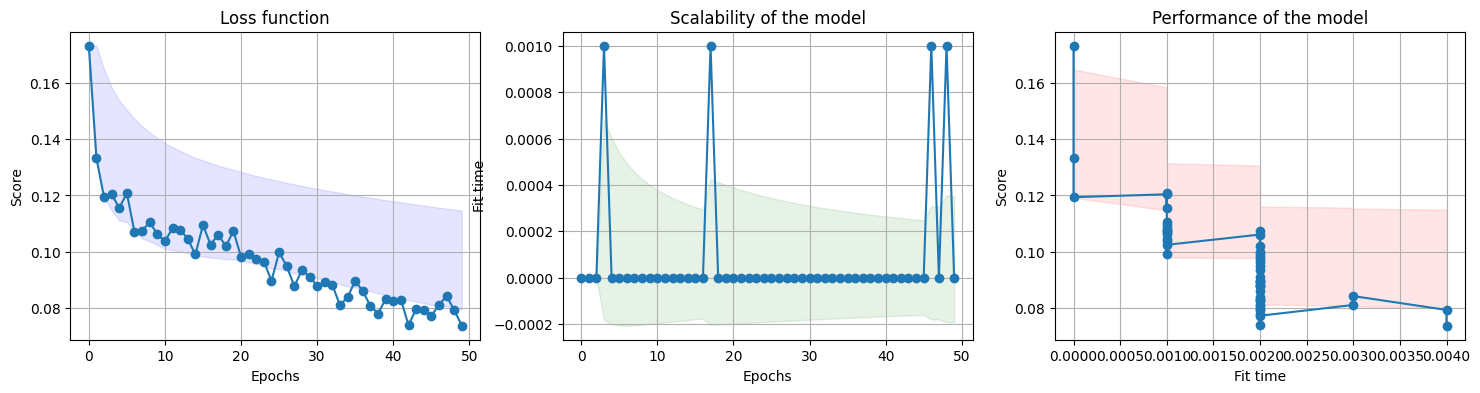

In [43]:
prompt_tuner.plot_learning_curve()

<a id="deploy"></a>
# Deploy

We deploy the model using the `model_id` variable.

In [44]:
model_id = prompt_tuner.get_run_details()['entity']['model_id']
print(model_id)

794e7a33-1b61-47c2-8efc-556411e4bab9


In [45]:
meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: "PT DEPLOYMENT SDK - project",
    client.deployments.ConfigurationMetaNames.ONLINE: {},
    client.deployments.ConfigurationMetaNames.SERVING_NAME : f"pt_sdk_deployment_{datetime.datetime.utcnow().strftime('%Y_%m_%d_%H%M%S')}"
}
deployment_details = client.deployments.create(model_id, meta_props)



#######################################################################################

Synchronous deployment creation for uid: '794e7a33-1b61-47c2-8efc-556411e4bab9' started

#######################################################################################


initializing
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='bb0a93ea-dfd8-4c00-b0ad-e94b8c1425f3'
------------------------------------------------------------------------------------------------




We store the deployment id, which will be used for inference.

In [ ]:
deployment_details

In [46]:
deployment_id = client.deployments.get_id(deployment_details)
print(deployment_id)

bb0a93ea-dfd8-4c00-b0ad-e94b8c1425f3


<a id="inference"></a>
# Run Foundation Models Inference on watsonx.ai



We define the generation parameters. 

- We use `greedy` decoding method because we want the model to return the most probable response (yes or no) for the given text.
- The overall token limit for inference of the tuned model is 4096 (inputs and outputs combined). 100 of them are saved for the tuned soft prompt, and 20 for the output, so 3976 tokens remain for the input. We set `TRUNCATE_INPUT_TOKENS` to 3975 to trim inputs which are longer than that.

In [47]:
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams

In [48]:
generate_params = {
    GenParams.MAX_NEW_TOKENS: 20,
    GenParams.DECODING_METHOD: 'greedy',
    GenParams.MIN_NEW_TOKENS: 1,
    GenParams.TRUNCATE_INPUT_TOKENS: 3975,
}

We define an instance of `ModelInference` using the `deployment_id` and the generation parameters.

In [49]:
from ibm_watsonx_ai.foundation_models import ModelInference

In [50]:
tuned_model = ModelInference(
    deployment_id=deployment_id,
    params=generate_params,
    api_client=client
)

## Run inference

If you chose to run with the demo data, we take the test data from the original CFPB dataframe. Otherwise, the test data is taken from the path specified in the variable `test_filepath` in the cell `Use your own data`.

Note: We perform the same preprocessing for the test set as done for the train set. It is assumed they share identical column names.

In [51]:
def get_demo_test_data(df):
    return df.loc[1000:1999, :]

def get_test_data(filepath):
    return pd.read_csv(filepath)

In [52]:
if not use_your_own_data:
    test_df = get_demo_test_data(df)
else:
    if test_filepath is None:
        raise Exception("you need set a path to a test file to continue (in cell \"Use your own data\")")
    test_df = get_test_data(test_filepath)
    test_df = preprocess_format(test_df)
    test_df = preprocess_multiclass_to_binary(test_df, text_column, label_column, positive_label_name)

We check there are both positive and negative examples in the test set.

In [53]:
eval_classes = set(test_df["output"])
if (len(eval_classes)) < 2:
    print(f'Note, you only have {"positive" if "yes" in eval_classes else "negative"} examples in your test set. It could be hard to deduce how well the model performs on them.')
else:
    print(f"Your test data contains {sum(test_df['output']=='yes')} positive and {sum(test_df['output']=='no')} negative examples")

Your test data contains 180 positive and 820 negative examples


In [54]:
prompts_batch = test_df["input"].tolist()
labels = test_df["output"].tolist()

We infer the tuned model over the test data.

Our model is expected to output `yes` for positive labels and `no` for negative ones, but occasionally the output of the model may yield a result which is not part of the original options. From our experiments, such hallucinations usually occur for ~1% of the examples on average.

For this purpose we use a utility function from the `difflib` package to find the most similar class to the generated text. If none is found, we classify this example as negative.

Note: In case inference fails, you may want to re-run the `Deploy` section and then try inference again.

In [55]:
import difflib

In [56]:
possible_predictions = ['yes', 'no']
start = time.time()
print(f"Running inference on {len(prompts_batch)} examples")
predictions = tuned_model.generate_text(prompt=prompts_batch)
predictions = [(difflib.get_close_matches(res, possible_predictions) + ['no'])[0] for res in predictions]
end = time.time()
print(f"elapsed time: {end - start}")

Running inference on 1000 examples
elapsed time: 76.77604627609253


<a id="evaluation"></a>
# Evaluate the tuned model

We evaluate the predictions with respect to the labels. We calculate accuracy, macro-f1 and f1 per class. Naturally, we are most interested in the f1 of the positive class.

In [57]:
from sklearn.metrics import f1_score, classification_report

In [58]:
def print_metrics(labels, predictions):
    f1 = f1_score(y_true=labels, y_pred=predictions, pos_label='yes')
    print(f'f1 score of {class_name} = ' + '{:.2f}'.format(f1))
    print('-- full classification report: --')
    print(classification_report(y_true=labels, y_pred=predictions))

In [59]:
print_metrics(labels, predictions)

f1 score of credit card = 0.74
-- full classification report: --
              precision    recall  f1-score   support

          no       0.95      0.93      0.94       820
         yes       0.71      0.77      0.74       180

    accuracy                           0.90      1000
   macro avg       0.83      0.85      0.84      1000
weighted avg       0.91      0.90      0.90      1000



## Compare to base model

This cell is optional, and is used to compare the tuned model to the same model in a zero-shot setup. On the dataset we are using in this notebook, the gain with the tuned model is around ~9 macro-f1 points.

We initialize the `ModelInference` class with base model, and infer over the test data.

We need to provide the base model with the zero-shot prompt for the task. We use the prompt that is defined in the `verbalizer`.

In [60]:
base_model = ModelInference(
    model_id=ModelTypes.FLAN_T5_XL,
    params=generate_params,
    api_client=client
)

In [61]:
base_prompts_batch = [verbalizer.replace("{{input}}", text) for text in test_df["input"]]

In [63]:
base_predictions = base_model.generate_text(prompt=base_prompts_batch)
base_predictions = [(difflib.get_close_matches(res, possible_predictions) + ['no'])[0] for res in base_predictions]

In [64]:
print_metrics(labels, base_predictions)

f1 score of credit card = 0.65
-- full classification report: --
              precision    recall  f1-score   support

          no       0.92      0.95      0.93       820
         yes       0.71      0.61      0.65       180

    accuracy                           0.88      1000
   macro avg       0.81      0.78      0.79      1000
weighted avg       0.88      0.88      0.88      1000



## Compute confusion matrix

For error analysis, we compute a confusion matrix using model predictions versus the gold labels, over the test set.

In [65]:
from sklearn.metrics import confusion_matrix

In [66]:
def compute_confusition_matrix(labels, predictions):
    cm = confusion_matrix(y_true=labels, y_pred=predictions, labels=possible_predictions)
    df = pd.DataFrame(cm)
    df.columns = possible_predictions
    df.index = possible_predictions
    print(df)

In [67]:
compute_confusition_matrix(labels, predictions)

     yes   no
yes  138   42
no    56  764


<a id="benchmark"></a>
# Benchmark Results

We compare the performance of PT with a Flan-T5-xl model tuned over 1K randomly selected labeled examples to a zero-shot Flan-t5-xl model. The evaluation is performed over 6 benchmark datasets, each data containing several classes. For each class, we run 3 PT processes and report the average f1 on the test set. Then, for each dataset we report the macro-f1 average over the results of each class. 

Our results show an average gain of 24 points when using PT over 1K examples. 

More details regarding the datasets:

* Watson Sentiment is an IBM internal dataset, while the rest are publicly available.
* Testing of all models is done on a separate random sample of 1K examples.
* Banking, News Classification and Ledgar datasets originally contain more than 5 classes. Due to limitation of resources, the results reported here are on 5 classes selected at random for each dataset.

| Dataset | Number of classes | Zero-shot| PT (this notebook)|
| --- | :-: | :-:| :-:|
|Watson Sentiment|  3 | 0.58 | 0.78
|CFPB   | 9  | 0.59 | 0.66 
|Ledgar (5 classes)|  5  | 0.31 | 0.63 
|Banking (5 classes) | 5 | 0.41 |  0.84  
|News Classification (5 classes) | 5 | 0.46 | 0.57 
|20 Newsgroup       | 20 | 0.55 | 0.76 
| ***Mean*** |  | 0.48 | 0.72 

<a id="summary"></a>
# Summary

Congratulations, you have successfully trained a model using watsonx PT!

Check out our <a href="https://ibm.github.io/watson-machine-learning-sdk/" target="_blank" rel="noopener no referrer">Online Documentation</a> for more samples, tutorials, documentation, how-tos, and blog posts.

**Author: Lena Dankin**, LM Utilization Team, IBM Research.

Copyright © 2024 IBM. This notebook and its source code are released under the terms of the MIT License.